In [1]:
# Importamos librerias
import os
import pickle
import datetime
import copy
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy as sp
import scipy.linalg as linalg
import sklearn as skl
import pandas as pd
import json
import torch
import torch.optim as optim
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import datasets
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Lambda, Compose
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torchviz import make_dot


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [3]:
# Definición de constantes
batch_size = 100
num_epochs = 100

labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

In [4]:
# Preparación de los datos

# Transformación de los datos
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

# Carga de los datos
train_set_orig = datasets.FashionMNIST('MNIST_data/', download = True, train = True,  transform = transform)
valid_set_orig = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)

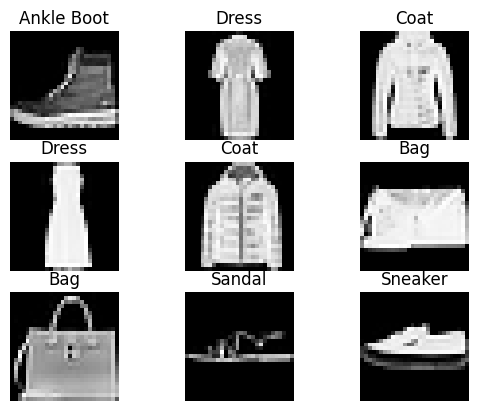

In [5]:
# Visualización de imágenes con sus etiquetas de clasificación
figure = plt.figure()
cols,rows = 3,3
for i in range(1,cols*rows+1):
    j = torch.randint(len(train_set_orig),size=(1,)).item()
    image,label = train_set_orig[j]
    figure.add_subplot(rows,cols,i)
    plt.title(labels[label])
    plt.axis("off")
    plt.imshow(image.squeeze(),cmap="Greys_r")
plt.show()

In [6]:
class CustomDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, i):
        image, _ = self.dataset[i]
        return image, image

# Convertimos los datasets originales a CustomDataset
train_set = CustomDataset(train_set_orig)
valid_set = CustomDataset(valid_set_orig)

print(f"Tamaño del dataset de entrenamiento: {len(train_set)}")
print(f"Tamaño del dataset de validación: {len(valid_set)}")

Tamaño del dataset de entrenamiento: 60000
Tamaño del dataset de validación: 10000


In [ ]:
# Creación del autoencoder convolucional
class ConvAutoencoder(nn.Module):
    def __init__(self, n, p=0.2):
        super(ConvAutoencoder, self).__init__()
        self.n = n
        self.p = p

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3),
            nn.ReLU(),
            nn.Dropout(self.p),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(16, 32, kernel_size=3),
            nn.ReLU(),
            nn.Dropout(self.p),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten(),
            nn.Linear(32 * 5 * 5, self.n),
            nn.ReLU(),
            nn.Dropout(self.p)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(self.n, 32 * 5 * 5),
            nn.ReLU(),
            nn.Dropout(self.p),
            nn.Unflatten(1, (32, 5, 5)),
            
            nn.ConvTranspose2d(32, 16, kernel_size=5, stride=2, padding=2, output_padding=0, dilation=2),
            #nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, output_padding=1),
            nn.ReLU(),
            nn.Dropout(self.p),

            nn.ConvTranspose2d(16, 1, kernel_size=6, stride=2, padding=1, output_padding=0, dilation=1),
            #nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, output_padding=1),
            #nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
model = ConvAutoencoder(n=256, p=0.2).to(device)
print(model)

# Prueba
image = torch.randn(1,1,28,28) 
output = model(image)
print(f'Input size: {image.shape}')
print(f'Output size: {output.shape}')

ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Dropout(p=0, inplace=False)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=800, out_features=256, bias=True)
    (10): ReLU()
    (11): Dropout(p=0, inplace=False)
  )
  (decoder): Sequential(
    (0): Linear(in_features=256, out_features=800, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Unflatten(dim=1, unflattened_size=(32, 5, 5))
    (4): ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), dilation=(2, 2))
    (5): ReLU()
    (6): Dropout(p=0, inplace=False)
    (7): ConvTranspose2d(16, 1, kernel_size=(6, 6), str

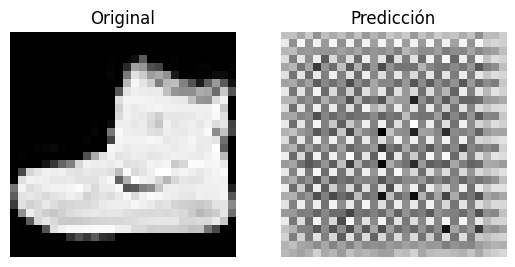

In [8]:
# Graficamos imágen original y predicción
example_input, example_output = train_set[0]

figure, axes = plt.subplots(1, 2)
example_input = example_input.unsqueeze(0).to(device)
with torch.no_grad():
    reconstructed = model(example_input).cpu()

axes[0].imshow(example_input.squeeze().cpu(), cmap="Greys_r")
axes[0].set_title("Original")
axes[0].axis("off")

axes[1].imshow(reconstructed.squeeze(), cmap="Greys_r")
axes[1].set_title("Predicción")
axes[1].axis("off")

plt.show()

# Datos sin entrenar, la predicción es solo ruido

In [9]:
# Loops de entrenamiento y validación
def train_loop(dataloader, model, loss_fn, optimizer, verbose=True):
    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_batch_avrg_loss = 0
    num_processed_samples = 0

    model.train()
    model = model.to(device)

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        batch_size = len(X)
        num_processed_samples += batch_size	

        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_avrg_loss = loss.item()
        sum_batch_avrg_loss += batch_avrg_loss

        if batch % max(num_batches // 10, 1) == 0 and verbose:
            current = batch*len(X)
            print(f'Batch {batch:>5d} | Loss: {batch_avrg_loss:.6f} | Processed: {100 * num_processed_samples / num_samples:.2f}%')

    avg_loss = sum_batch_avrg_loss / num_batches
    return avg_loss

def eval_loop(dataloader, model, loss_fn):
    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_batch_avrg_loss = 0
    num_processed_samples = 0

    model.eval()
    model = model.to(device)

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            batch_size = len(X)
            num_processed_samples += batch_size

            pred = model(X)
            loss = loss_fn(pred, y)

            batch_avrg_loss = loss.item()
            sum_batch_avrg_loss += batch_avrg_loss

    avg_loss = sum_batch_avrg_loss / num_batches
    print(f'Validation | Avg Loss: {avg_loss:.6f}')

    return avg_loss

In [10]:
# Inicializamos DataLoaders
batch_size = 100
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)

num_train_batches = len(train_loader)
num_valid_batches = len(valid_loader)
print('num_train_batches: ', num_train_batches)
print('num_valid_batches: ', num_valid_batches)

# Función de pérdida (Error Cuadrático Medio)
loss_fn = nn.MSELoss()

# Optimizador ADAM
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate, eps=1e-8, weight_decay=0, amsgrad=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

num_train_batches:  600
num_valid_batches:  100


In [11]:
# Entrenamiento del modelo
num_epochs = 60
list_avg_train_loss_incorrecta = []
list_avg_train_loss = []
list_avg_valid_loss = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}\\n' + '-' * 20)
    avg_train_loss_incorrecta = train_loop(train_loader, model, loss_fn, optimizer)
    avg_train_loss = eval_loop(train_loader, model, loss_fn)
    avg_valid_loss = eval_loop(valid_loader, model, loss_fn)

    list_avg_train_loss_incorrecta.append(avg_train_loss_incorrecta)
    list_avg_train_loss.append(avg_train_loss)
    list_avg_valid_loss.append(avg_valid_loss)  

    print('avg_train_loss_incorrecta: ', avg_train_loss_incorrecta)
    print('avg_train_loss: ', avg_train_loss)
    print('avg_valid_loss: ', avg_valid_loss)

# Guardamos solo los pesos del autoencoder
# encoder_path = "autoencoder_weights.pth"
# torch.save(model.state_dict(), encoder_path)

print('Entranamiento completo')

Epoch 1\n--------------------
Batch     0 | Loss: 0.613124 | Processed: 0.17%
Batch    60 | Loss: 0.197178 | Processed: 10.17%
Batch   120 | Loss: 0.132976 | Processed: 20.17%
Batch   180 | Loss: 0.110081 | Processed: 30.17%
Batch   240 | Loss: 0.100518 | Processed: 40.17%
Batch   300 | Loss: 0.085815 | Processed: 50.17%
Batch   360 | Loss: 0.085155 | Processed: 60.17%
Batch   420 | Loss: 0.082443 | Processed: 70.17%
Batch   480 | Loss: 0.080495 | Processed: 80.17%
Batch   540 | Loss: 0.077937 | Processed: 90.17%
Validation | Avg Loss: 0.074611
Validation | Avg Loss: 0.074928
avg_train_loss_incorrecta:  0.12640697886546454
avg_train_loss:  0.07461072451124588
avg_valid_loss:  0.074927579164505
Epoch 2\n--------------------
Batch     0 | Loss: 0.075643 | Processed: 0.17%
Batch    60 | Loss: 0.077373 | Processed: 10.17%
Batch   120 | Loss: 0.074633 | Processed: 20.17%
Batch   180 | Loss: 0.077095 | Processed: 30.17%
Batch   240 | Loss: 0.063613 | Processed: 40.17%
Batch   300 | Loss: 0.0

In [11]:
# Guardamos las pérdidas para su posterior análisis a traves de gráficos
# np.save(r'.\autoencoder\train_loss_256.npy', list_avg_train_loss)
# np.save(r'.\autoencoder\train_loss_incorrecta_256.npy', list_avg_train_loss_incorrecta)
# np.save(r'.\autoencoder\valid_loss_256.npy', list_avg_valid_loss)
np.save(r'.\autoencoder\train_loss_without_dropout.npy', list_avg_train_loss)
np.save(r'.\autoencoder\train_loss_incorrecta_without_dropout.npy', list_avg_train_loss_incorrecta)
np.save(r'.\autoencoder\valid_loss_without_dropout.npy', list_avg_valid_loss)

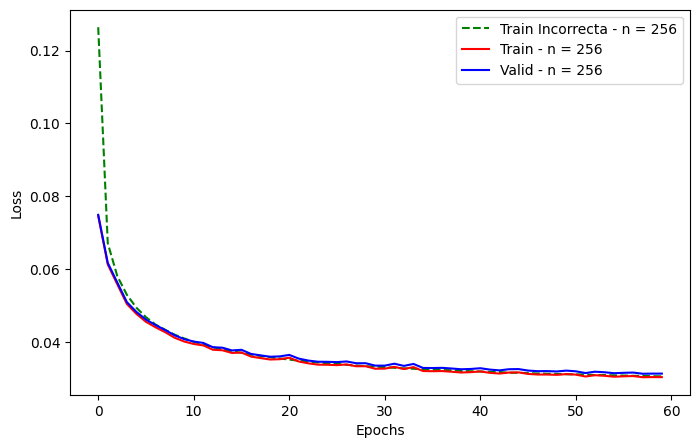

In [18]:
# Graficamos loss en función de las épocas
plt.figure(figsize=(8,5))
plt.plot(list_avg_train_loss_incorrecta, 'g--', label='Train Incorrecta - n = 256')
plt.plot(list_avg_train_loss, 'r-', label='Train - n = 256')
plt.plot(list_avg_valid_loss, 'b-', label='Valid - n = 256')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

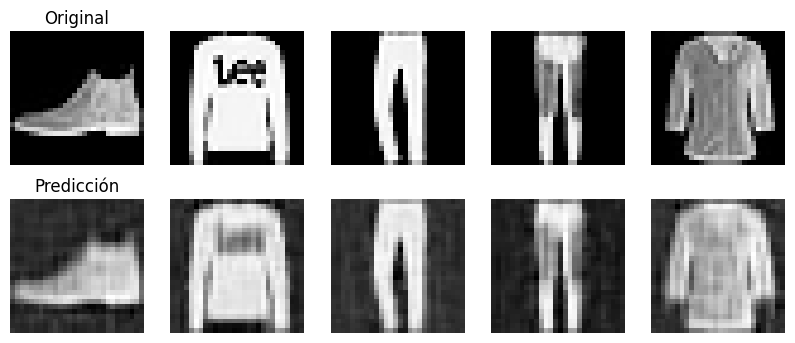

In [12]:
# Graficamos imágenes originales y predicciones
figure, axes = plt.subplots(2, 5, figsize=(10, 4))
model.eval()
with torch.no_grad():
    for i in range(5):
        img, _ = valid_set[i]
        img = img.unsqueeze(0).to(device)
        reconstructed = model(img).cpu()
        axes[0, i].imshow(img.squeeze().cpu(), cmap="Greys_r")
        axes[0, i].axis("off")
        axes[1, i].imshow(reconstructed.squeeze(), cmap="Greys_r")
        axes[1, i].axis("off")
axes[0, 0].set_title("Original")
axes[1, 0].set_title("Predicción")
plt.show()

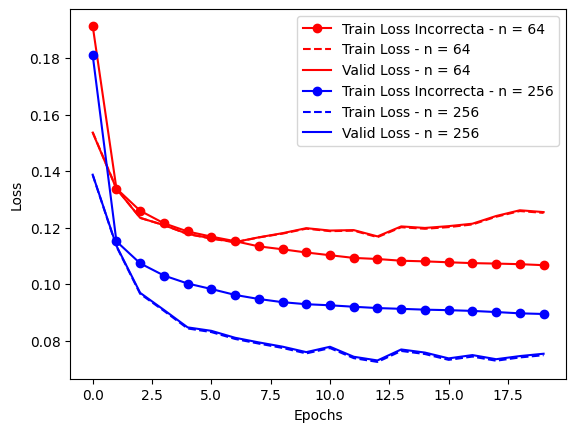

In [42]:
# Graficamos comparación de loss con n = 64 y n = 256
train_loss_incorrecta_64 = np.load(r'.\autoencoder\train_loss_incorrecta_64.npy')
train_loss_64 = np.load(r'.\autoencoder\train_loss_64.npy')
valid_loss_64 = np.load(r'.\autoencoder\valid_loss_64.npy')


train_loss_incorrecta_256 = np.load(r'.\autoencoder\train_loss_incorrecta_256.npy')
train_loss_256 = np.load(r'.\autoencoder\train_loss_256.npy')
valid_loss_256 = np.load(r'.\autoencoder\valid_loss_256.npy')

plt.figure()

plt.plot(train_loss_incorrecta_64,'ro-', label='Train Loss Incorrecta - n = 64')
plt.plot(train_loss_64,'r--', label='Train Loss - n = 64')
plt.plot(valid_loss_64,'r-', label='Valid Loss - n = 64')

plt.plot(train_loss_incorrecta_256,'bo-', label='Train Loss Incorrecta - n = 256')
plt.plot(train_loss_256,'b--', label='Train Loss - n = 256')
plt.plot(valid_loss_256,'b-', label='Valid Loss - n = 256')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

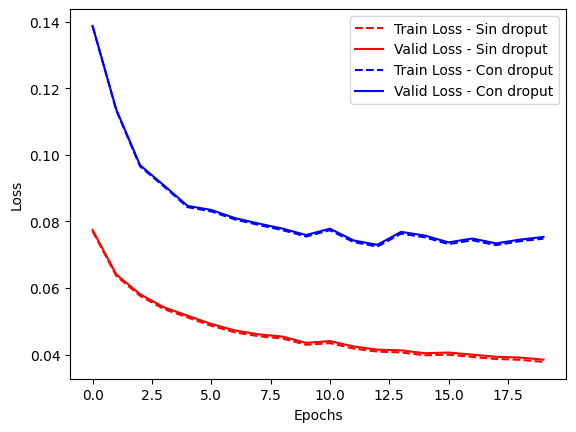

In [12]:
# Graficamos comparación de loss con n = 64 y n = 256
train_loss_incorrecta_without_dropout = np.load(r'.\autoencoder\train_loss_incorrecta_without_dropout.npy')
train_loss_without_dropout = np.load(r'.\autoencoder\train_loss_without_dropout.npy')
valid_loss_without_dropout = np.load(r'.\autoencoder\valid_loss_without_dropout.npy')


train_loss_incorrecta_256 = np.load(r'.\autoencoder\train_loss_incorrecta_256.npy')
train_loss_256 = np.load(r'.\autoencoder\train_loss_256.npy')
valid_loss_256 = np.load(r'.\autoencoder\valid_loss_256.npy')

plt.figure()

# plt.plot(train_loss_incorrecta_without_dropout,'ro-', label='Train Loss Incorrecta')
plt.plot(train_loss_without_dropout,'r--', label='Train Loss - Sin droput')
plt.plot(valid_loss_without_dropout,'r-', label='Valid Loss - Sin droput')

# plt.plot(train_loss_incorrecta_256,'bo-', label='Train Loss Incorrecta')
plt.plot(train_loss_256,'b--', label='Train Loss - Con droput')
plt.plot(valid_loss_256,'b-', label='Valid Loss - Con droput')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Clasificador Convolucional

In [13]:
class ClsfAutoencoder(nn.Module):
    def __init__(self, autoencoder=None, n=64, p=0.2):
        super(ClsfAutoencoder, self).__init__()
        if autoencoder is None:
            self.n = n
            self.p = p

            # Encoder
            self.encoder = nn.Sequential(
                nn.Conv2d(1, 16, kernel_size=3),
                nn.ReLU(),
                nn.Dropout(self.p),
                nn.MaxPool2d(kernel_size=2, stride=2),

                nn.Conv2d(16, 32, kernel_size=3),
                nn.ReLU(),
                nn.Dropout(self.p),
                nn.MaxPool2d(kernel_size=2, stride=2),

                nn.Flatten(),
                nn.Linear(32 * 5 * 5, self.n),
                nn.ReLU(),
                nn.Dropout(self.p)
            )
        else:
            self.encoder = copy.deepcopy(autoencoder.encoder)
            self.n = autoencoder.n
            self.p = autoencoder.p
        
        self.clasiffier = nn.Sequential(
            nn.Linear(self.n, 10),
            #nn.Sigmoid(),
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.clasiffier(x)
        return x

conv_autoencoder = ConvAutoencoder(n=256, p=0.2).to(device)
conv_autoencoder.load_state_dict(torch.load("autoencoder_weights.pth")) # Cargamos los pesos del autoencoder previamente entrenado
clsf_model = ClsfAutoencoder(autoencoder=conv_autoencoder, n=256, p=0.2)
#clsf_model = ClsfAutoencoder(autoencoder=None, n=256, p=0.2)
clsf_model = clsf_model.to(device)
print(clsf_model)

ClsfAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=800, out_features=256, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
  )
  (clasiffier): Sequential(
    (0): Linear(in_features=256, out_features=10, bias=True)
  )
)


C:\Users\ignam\AppData\Local\Temp\ipykernel_13784\2420458378.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  conv_autoencoder.load_state_dict(torch.load("autoencoder_we

In [14]:
# Loops de entrenamiento y validación
def clsf_train_loop(dataloader, model, loss_fn, optimizer, verbose=True):
    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_batch_avrg_loss = 0
    sum_correct = 0
    num_processed_samples = 0

    model.train()
    model = model.to(device)

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        batch_size = len(X)
        num_processed_samples += batch_size	

        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_avrg_loss = loss.item()
        sum_batch_avrg_loss += batch_avrg_loss
        sum_correct += (pred.argmax(dim=1) == y).type(torch.float).sum().item()

        if batch % max(num_batches // 10, 1) == 0 and verbose:
            current = batch*len(X)
            print(f'Batch {batch:>5d} | Loss: {batch_avrg_loss:.6f} | Processed: {100 * num_processed_samples / num_samples:.2f}%')

    avg_loss = sum_batch_avrg_loss / num_batches
    precision = sum_correct / num_samples

    return avg_loss, precision

def clsf_eval_loop(dataloader, model, loss_fn):
    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_batch_avrg_loss = 0
    num_processed_samples = 0
    sum_correct = 0

    model.eval()
    model = model.to(device)

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            batch_size = len(X)
            num_processed_samples += batch_size

            pred = model(X)
            loss = loss_fn(pred, y)

            batch_avrg_loss = loss.item()
            sum_batch_avrg_loss += batch_avrg_loss
            sum_correct += (pred.argmax(dim=1) == y).type(torch.float).sum().item()

    avg_loss = sum_batch_avrg_loss / num_batches
    precision = sum_correct / num_samples
    print(f'Validation | Precision: {100 * precision:.1f}% | Avg Loss: {avg_loss:.6f}')

    return avg_loss, precision

In [15]:
# Inicializamos DataLoaders
batch_size = 100
train_loader = DataLoader(train_set_orig, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set_orig, batch_size=batch_size, shuffle=False)

# Función de pérdida (Cross Entropy Loss)
loss_fn = nn.CrossEntropyLoss()

# Optimizador ADAM
learning_rate = 1e-3
optimizer = optim.Adam(clsf_model.clasiffier.parameters(), lr=learning_rate, eps=1e-8, weight_decay=0, amsgrad=False) # Entrenar solo clasificador
#optimizer = optim.Adam(clsf_model.parameters(), lr=learning_rate, eps=1e-8, weight_decay=0, amsgrad=False)

In [16]:
# Entrenamiento del modelo
num_epochs = 20
list_avg_train_loss_incorrecta = []
list_avg_train_loss = []
list_avg_valid_loss = []
list_precision_train_incorrecta  = []
list_precision_train = []
list_precision_valid = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}\\n' + '-' * 20)
    avg_train_loss_incorrecta, precision_train_incorrecta = clsf_train_loop(train_loader, clsf_model, loss_fn, optimizer)
    avg_train_loss, precision_train = clsf_eval_loop(train_loader, clsf_model, loss_fn)
    avg_valid_loss, precision_valid = clsf_eval_loop(valid_loader, clsf_model, loss_fn)

    list_avg_train_loss_incorrecta.append(avg_train_loss_incorrecta)
    list_avg_train_loss.append(avg_train_loss)
    list_avg_valid_loss.append(avg_valid_loss)
    list_precision_train_incorrecta.append(precision_train_incorrecta)
    list_precision_train.append(precision_train)
    list_precision_valid.append(precision_valid)

    print('avg_train_loss_incorrecta: ', avg_train_loss_incorrecta)
    print('avg_train_loss: ', avg_train_loss)
    print('avg_valid_loss: ', avg_valid_loss)

print('Entranamiento completo')

Epoch 1\n--------------------
Batch     0 | Loss: 2.346261 | Processed: 0.17%
Batch    60 | Loss: 1.829512 | Processed: 10.17%
Batch   120 | Loss: 1.473139 | Processed: 20.17%
Batch   180 | Loss: 1.221359 | Processed: 30.17%
Batch   240 | Loss: 1.097591 | Processed: 40.17%
Batch   300 | Loss: 1.022335 | Processed: 50.17%
Batch   360 | Loss: 0.918344 | Processed: 60.17%
Batch   420 | Loss: 0.807733 | Processed: 70.17%
Batch   480 | Loss: 0.913082 | Processed: 80.17%
Batch   540 | Loss: 0.797418 | Processed: 90.17%
Validation | Precision: 80.0% | Avg Loss: 0.917019
Validation | Precision: 79.3% | Avg Loss: 0.930089
avg_train_loss_incorrecta:  1.1350736961762111
avg_train_loss:  0.9170191690325737
avg_valid_loss:  0.9300892454385757
Epoch 2\n--------------------
Batch     0 | Loss: 0.607889 | Processed: 0.17%
Batch    60 | Loss: 0.820542 | Processed: 10.17%
Batch   120 | Loss: 0.653647 | Processed: 20.17%
Batch   180 | Loss: 0.688933 | Processed: 30.17%
Batch   240 | Loss: 0.596835 | Proc

In [29]:
# Guardamos la loss y la precision para su posterior análisis a traves de gráficos

np.save(r'.\classifier\train_loss_pretrain.npy', list_avg_train_loss)
np.save(r'.\classifier\train_loss_incorrecta_pretrain.npy', list_avg_train_loss_incorrecta)
np.save(r'.\classifier\valid_loss_pretrain.npy', list_avg_valid_loss)

np.save(r'.\classifier\precision_train_pretrain.npy', list_precision_train)
np.save(r'.\classifier\precision_train_incorrecta_pretrain.npy', list_precision_train_incorrecta)
np.save(r'.\classifier\precision_valid_pretrain.npy', list_precision_valid)

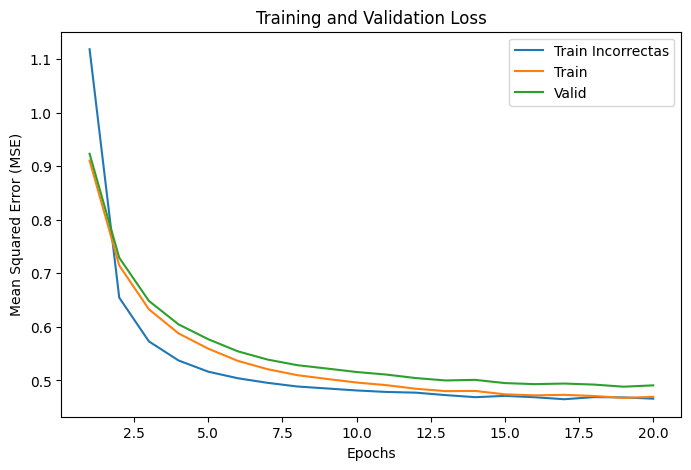

In [30]:
# Graficamos loss en función de las épocas
plt.figure(figsize=(8,5))
plt.plot(list(range(1, len(list_avg_train_loss_incorrecta)+1)), list_avg_train_loss_incorrecta, label='Train Incorrectas')
plt.plot(list(range(1, len(list_avg_train_loss)+1)), list_avg_train_loss, label='Train')
plt.plot(list(range(1, len(list_avg_valid_loss)+1)), list_avg_valid_loss, label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

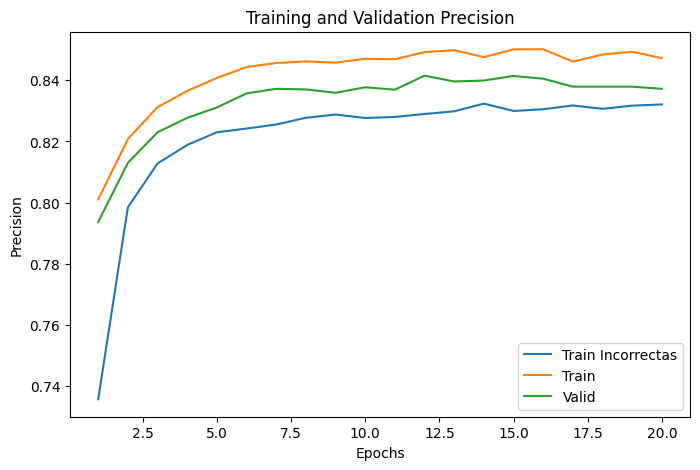

In [31]:
# Graficamos precisión en función de las épocas
plt.figure(figsize=(8,5))
plt.plot(list(range(1, len(list_precision_train_incorrecta)+1)), list_precision_train_incorrecta, label='Train Incorrectas')
plt.plot(list(range(1, len(list_precision_train)+1)), list_precision_train, label='Train')
plt.plot(list(range(1, len(list_precision_valid)+1)), list_precision_valid, label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.title('Training and Validation Precision')
plt.show()

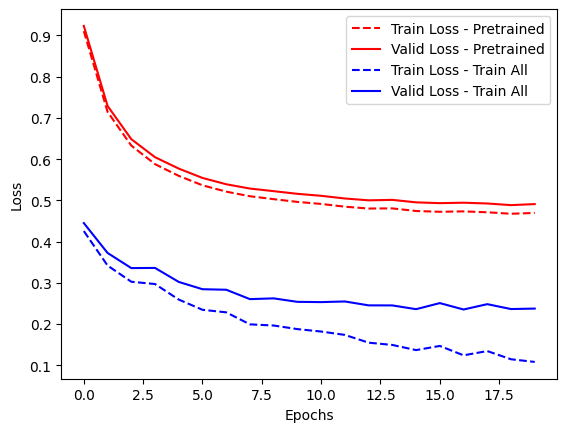

In [40]:
# Graficamos comparación de loss de preentrenamiento y entrenamiento completo

train_loss_incorrecta_pretrain = np.load(r'.\classifier\train_loss_incorrecta_pretrain.npy')
train_loss_pretrain = np.load(r'.\classifier\train_loss_pretrain.npy')
valid_loss_pretrain = np.load(r'.\classifier\valid_loss_pretrain.npy')

train_loss_incorrecta = np.load(r'.\classifier\train_loss_incorrecta_train_all.npy')
train_loss = np.load(r'.\classifier\train_loss_train_all.npy')
valid_loss = np.load(r'.\classifier\valid_loss_train_all.npy')

plt.figure()
#plt.plot(train_loss_incorrecta_pretrain,'ro-', label='Train Loss Incorrecta - Pretrain')
plt.plot(train_loss_pretrain,'r--', label='Train Loss - Pretrained')
plt.plot(valid_loss_pretrain,'r-', label='Valid Loss - Pretrained')

#plt.plot(train_loss_incorrecta,'bo-', label='Train Loss Incorrecta - Train All')
plt.plot(train_loss,'b--', label='Train Loss - Train All')
plt.plot(valid_loss,'b-', label='Valid Loss - Train All')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


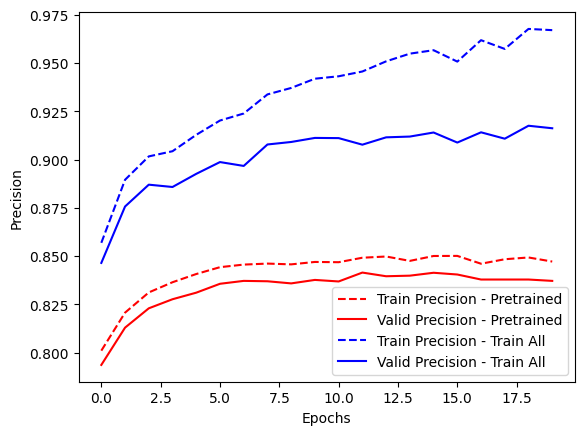

In [41]:
# Graficamos comparación de precisión de preentrenamiento y entrenamiento completo

precision_train_pretrain = np.load(r'.\classifier\precision_train_pretrain.npy')
precision_train_incorrecta_pretrain = np.load(r'.\classifier\precision_train_incorrecta_pretrain.npy')
precision_valid_pretrain = np.load(r'.\classifier\precision_valid_pretrain.npy')

precision_train = np.load(r'.\classifier\precision_train_train_all.npy')
precision_train_incorrecta = np.load(r'.\classifier\precision_train_incorrecta_train_all.npy')
precision_valid = np.load(r'.\classifier\precision_valid_train_all.npy')

plt.figure()
#plt.plot(precision_train_incorrecta_pretrain,'ro-', label='Train Precision Incorrecta - Pretrain')
plt.plot(precision_train_pretrain,'r--', label='Train Precision - Pretrained')
plt.plot(precision_valid_pretrain,'r-', label='Valid Precision - Pretrained')

#plt.plot(precision_train_incorrecta,'bo-', label='Train Precision Incorrecta - Train All')
plt.plot(precision_train,'b--', label='Train Precision - Train All')
plt.plot(precision_valid,'b-', label='Valid Precision - Train All')

plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.legend()
plt.show()

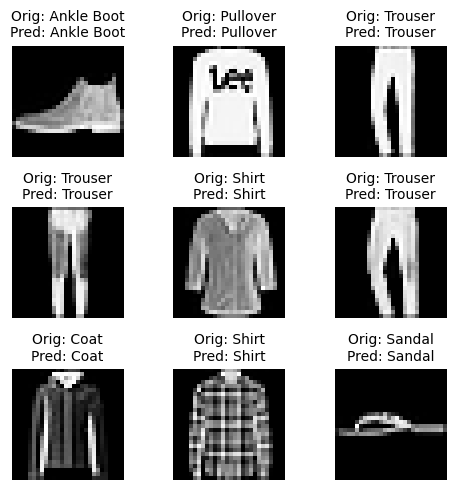

In [17]:
# Graficamos imágenes originales y predicciones del clasificador
figure, axes = plt.subplots(3, 3, figsize=(5, 5))  
clsf_model.eval()
with torch.no_grad():
    for i in range(9):  # Ahora mostramos 9 imágenes
        img, label = valid_set_orig[i]
        img = img.unsqueeze(0).to(device)
        pred = clsf_model(img).cpu()
        pred_label = pred.argmax(dim=1).item()  # Obtiene la clase predicha
        
        # Graficar la imagen original con etiquetas
        row, col = divmod(i, 3)  # Obtener posición en la cuadrícula
        axes[row, col].imshow(img.squeeze().cpu(), cmap="Greys_r")
        axes[row, col].axis("off")
        axes[row, col].set_title(f"Orig: {labels[label]}\nPred: {labels[pred_label]}", fontsize=10)

plt.tight_layout()
plt.show()


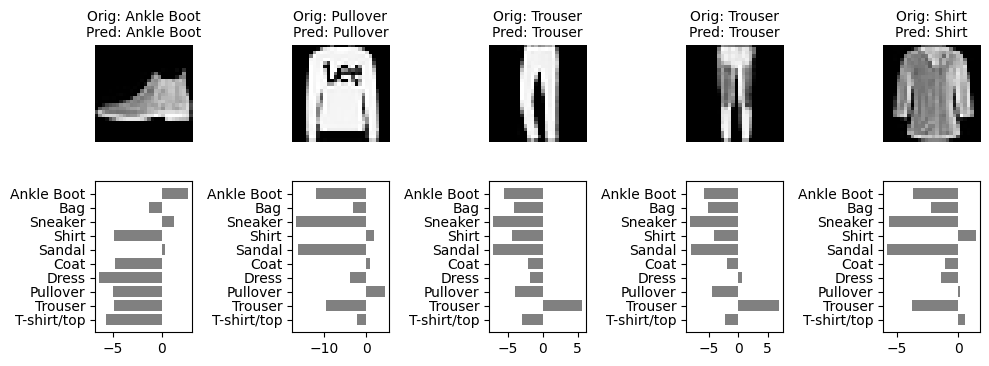

In [ ]:
# Graficamos imágenes originales y predicciones del clasificador
figure, axes = plt.subplots(5, 2, figsize=(10, 20))
clsf_model.eval()
with torch.no_grad():
    for i in range(5):
        img, label = valid_set_orig[i]
        img = img.unsqueeze(0).to(device)
        pred = clsf_model(img).cpu()
        pred_label = pred.argmax(dim=1).item()  # Obtiene la clase predicha
        
        # Graficar la imagen original
        axes[0, i].imshow(img.squeeze().cpu(), cmap="Greys_r")
        axes[0, i].axis("off")
        axes[0, i].set_title(f"Orig: {labels[label]}\nPred: {labels[pred_label]}", fontsize=10)

plt.tight_layout()
plt.show()


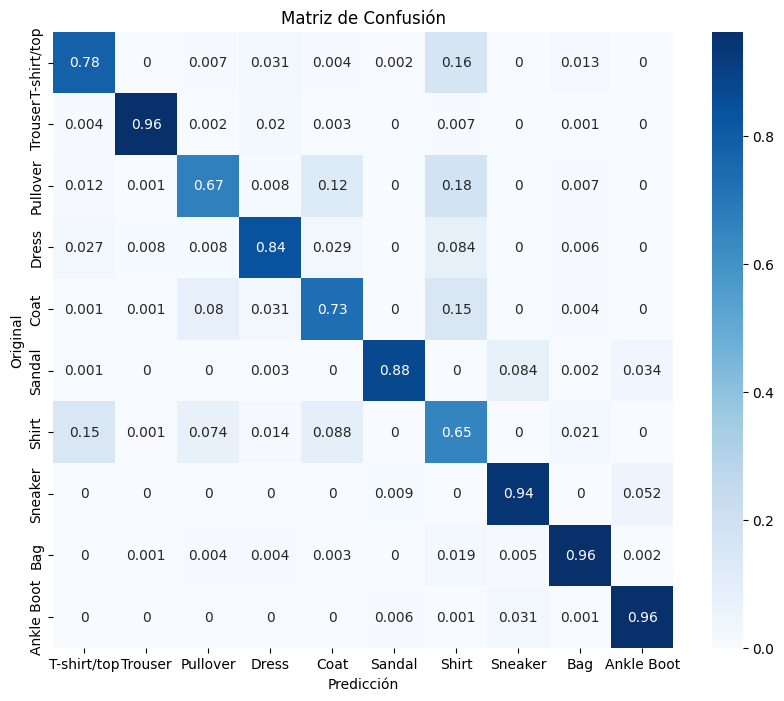

In [ ]:
# Graficamos matriz de confusión

clsf_model.eval()
with torch.no_grad():
    y_true = []
    y_pred = []
    for img, label in valid_loader:
        img = img.to(device)
        pred = clsf_model(img).cpu()
        y_true.extend(label)
        y_pred.extend(pred.argmax(dim=1))
    y_true = torch.stack(y_true).numpy()
    y_pred = torch.stack(y_pred).numpy()

cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm/np.sum(cm, axis=1)[:, None] , index=labels, columns=labels)

plt.figure(figsize=(10, 8))
sns.heatmap(df_cm, annot=True, xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Original')
plt.show()